In [38]:
# Python
# Third
# Property
import yfinance as yf
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
import math
import matplotlib.pyplot as plt
import warnings
from ipywidgets import IntProgress, FloatProgress
from IPython.display import display

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 150)


### TODO
- Type hint
- Field
- Optional
- Document functions
- Pytest
- log

In [39]:
# Parameters
LST_B3_STOCKS = ["RRRP3", "ALOS3", "ALPA4", "ABEV3", "ASAI3", "AZUL4", "AZZA3", "B3SA3", "BBSE3", "BBDC3", "BBDC4", "BRAP4", "BBAS3", "BRKM5", "BRFS3", "BPAC11", "CRFB3", "CCRO3", "CMIG4", "COGN3", "CPLE6", "CSAN3", "CPFE3", "CMIN3", "CVCB3", "CYRE3", "DXCO3", "ELET3", "ELET6", "EMBR3", "ENGI11", "ENEV3", "EGIE3", "EQTL3", "EZTC3", "FLRY3", "GGBR4", "GOAU4", "NTCO3", "HAPV3", "HYPE3", "IGTI11", "IRBR3", "ITSA4", "ITUB4", "JBSS3", "KLBN11", "RENT3", "LREN3", "LWSA3", "MGLU3", "MRFG3", "BEEF3", "MRVE3", "MULT3", "PCAR3", "PETR3", "PETR4", "RECV3", "PRIO3", "PETZ3", "RADL3", "RAIZ4", "RDOR3", "RAIL3", "SBSP3", "SANB11", "SMTO3", "CSNA3", "SLCE3", "SUZB3", "TAEE11", "VIVT3", "TIMS3", "TOTS3", "TRPL4", "UGPA3", "USIM5", "VALE3", "VAMO3", "VBBR3", "VIVA3", "WEGE3", "YDUQ3"]
PATH_LS_DATA = 'ls_data/'

In [40]:
def get_yahoo_asset_data(lst_stock_tickers, start_date, end_date = None):
    lst_assets=[]
    for ticker in lst_stock_tickers:
        df_stock = yf.download(ticker+'.SA', start = start_date, end = end_date, progress=False)
        
        if len(df_stock) != 0:
            df_stock = df_stock.loc[:,["Adj Close"]]
            df_stock.loc[:, "ticker"] = ticker
            lst_assets.append(df_stock)

    return pd.concat(lst_assets)

def pivote_asset_data(df):
    # Reseting index to pivoting
    df.reset_index(inplace = True)
    
    # Pivoting Data
    df = df.pivot(index = "Date", columns = "ticker", values = "Adj Close")
    
    # Renaming index
    df.index.names = ['date']

    # Fill NA
    df = df.fillna(method='ffill')

    return df

def create_long_short_dataset(lst_stock_tickers, start_date, end_date, source = 'yahoo'):
    if source == 'yahoo':
        df = get_yahoo_asset_data(lst_stock_tickers = LST_B3_STOCKS, start_date = "2018-01-01", end_date = None)
        df = pivote_asset_data(df)
        df.to_csv(PATH_LS_DATA+'yahoo_long_short_data.csv')
    else:
        pass

def load_long_short_dataset(max_date = None, source = 'yahoo'):
    if source == 'yahoo':
        if max_date == None:
            return pd.read_csv(PATH_LS_DATA+'yahoo_long_short_data.csv', index_col = 'date').reset_index()
        else:
            return pd.read_csv(PATH_LS_DATA+'yahoo_long_short_data.csv', index_col = 'date').loc[:max_date].reset_index()
    else:
        pass
    
def getPairs(df):
    assets = list(df.columns)
    assets.remove('date')
    
    lst_pairs = []
    for first in assets:
        for second in assets:
            if first != second:
                lst_pairs.append(first+'/'+second)
                
    return lst_pairs

def getPairsResiduals(lst_pairs, df_stocks, date_col = 'date', periods = 252):
    df_residuals = pd.DataFrame()
    df_residuals[date_col] = df_stocks[date_col].sort_values(ascending = False)[:periods]
    
    pairs_column = []
    p_values = []
    adf_column = []
    beta_column = []
    desv_column = []
    halflife_column = []
    
    progress_bar = IntProgress(min=0, max=len(lst_pairs))
    display(progress_bar)
    for i, pair in enumerate(lst_pairs):
        progress_bar.value = i+1
        
        asset1 = pair.split('/')[0]
        asset2 = pair.split('/')[1]
        
        df_res = df_stocks[[date_col, asset1, asset2]].sort_values(by=date_col, ascending = False)[:periods]
        
        X = df_res.iloc[:, 1].values.reshape(-1, 1)
        Y = df_res.iloc[:, 2].values.reshape(-1, 1)
        
        # Ignoring pairs with NaN values
        if df_res.iloc[:, 1].isna().sum() > 0 or df_res.iloc[:, 2].isna().sum() > 0:
            continue

        linear_regressor = LinearRegression()
        linear_regressor.fit(X, Y)
        
        Y_pred = linear_regressor.predict(X)
        df_res['residual'] = Y_pred - Y
        
        df_residuals[pair] = df_res['residual']
        
        mean = df_res['residual'].mean()
        std = df_res['residual'].std()
        
        adf = adfuller(df_res['residual'])
        adf_column.append(adf[0])
        p_values.append((1-adf[1])*100)
        pairs_column.append(pair) 
        beta_column.append(linear_regressor.coef_[0])
        desv_column.append(abs((df_res['residual'].iloc[0] - mean)/std))
        halflife_column.append(math.log(2)/linear_regressor.coef_[0])
    
    dict_stats = {'pair':pairs_column,
                  'adf':adf_column,
                  'beta':beta_column,
                  'desv':desv_column,
                  'halflife':halflife_column,
                  'p_value':p_values
                 }
    
    df_stats = pd.DataFrame(dict_stats)
    
    return df_residuals, df_stats

def double_cointegration(df, check = False):
    if check == True:
        lst_pairs = list(df.pair)
        double_cointegration_pairs = []
        for pair in lst_pairs:
            inverted_pair = pair.split('/')[1]+'/'+pair.split('/')[0]
            if inverted_pair in lst_pairs:
                double_cointegration_pairs.append(pair)
        return df[df["pair"].isin(double_cointegration_pairs)]
    else:
        return df

In [41]:
create_long_short_dataset(LST_B3_STOCKS, "2018-01-01", None, source = 'yahoo')

In [42]:
df_stocks = load_long_short_dataset()
lst_pairs = getPairs(df_stocks)

## L&S Screaning

Gerênciamento de risco
- 160 períodos: 1/3 do Capital para cada trade.
- 200 períodos: 1/2 do Capital para cada trade.
- 252 períodos: 100% do Capital para cada trade.


Teste ADF
- 1% -4,32%
- 5% -3,78%
- 10% -3,50%

Interpretação do Beta
- Para cada 1 real do ativo 1, operar beta*reais do ativo 2

In [49]:
prds = [252]
lst_df_pairs_res = []
lst_df_pairs_stats = []
for periodo in prds:
    print(f"Calculando estatísticas para período de {periodo} dias...")
    df_pairs_res, df_pairs_stats = getPairsResiduals(lst_pairs, df_stocks, date_col = 'date', periods = periodo)
    lst_df_pairs_res.append(df_pairs_res)
    lst_df_pairs_stats.append(df_pairs_stats)

Calculando estatísticas para período de 252 dias...


IntProgress(value=0, max=6972)

In [50]:
prd_index = 0
df_pairs_res = lst_df_pairs_res[prd_index]
df_pairs_stats = lst_df_pairs_stats[prd_index]

df_screaning = df_pairs_stats[
    (df_pairs_stats['adf'] <= -4.32) & 
    (df_pairs_stats['desv'] >= 1.00) & 
    (df_pairs_stats['desv'] < 2.5) & 
    (df_pairs_stats['beta'] >= 0.5) & 
    (df_pairs_stats['beta'] < 2) & 
    (df_pairs_stats['halflife'] <= 999)].sort_values(by='desv', ascending=False)

df_screaning = double_cointegration(df_screaning, check = True)

df_screaning.reset_index(drop=True)

,pair,adf,beta,desv,halflife,p_value
0,HYPE3/EZTC3,-5.221615,[0.8381181324086913],1.241165,[0.8270280211786972],99.999206
1,EZTC3/HYPE3,-5.262341,[1.0739298130660087],1.055453,[0.645430615787683],99.999345


HYPE3/EZTC3
Beta:  0.8381181324086913
Desv:  1.2411648876798898
Halflife:  0.8270280211786972


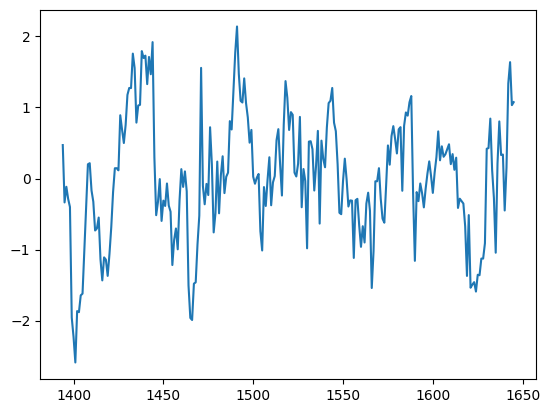

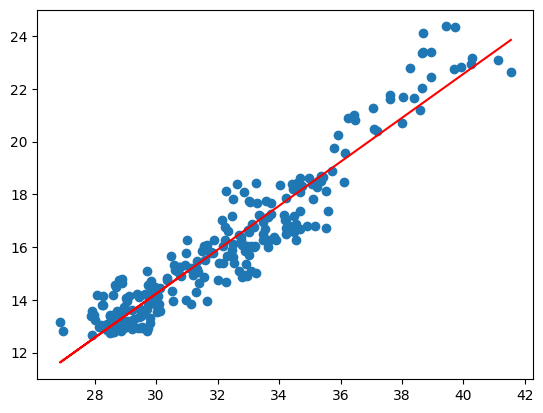

EZTC3/HYPE3
Beta:  1.0739298130660087
Desv:  1.0554531968238872
Halflife:  0.645430615787683


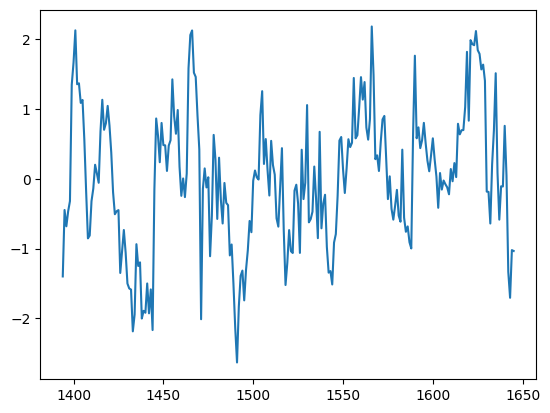

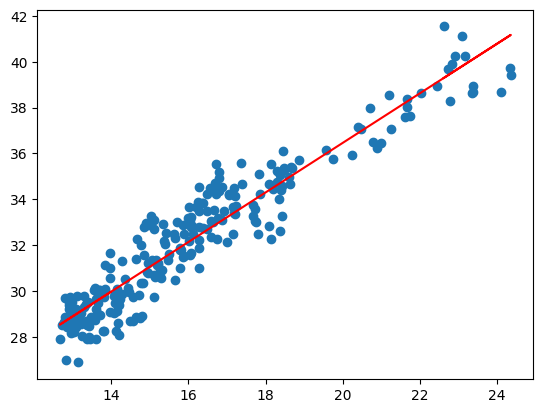

In [51]:
for n_pair in range(len(df_screaning)):

    print(df_screaning.iloc[n_pair,0])
    print("Beta: ", df_screaning.iloc[n_pair,2][0])
    print("Desv: ", df_screaning.iloc[n_pair,3])
    print("Halflife: ", df_screaning.iloc[n_pair,4][0])

    # Residual
    pair1 = df_screaning.iloc[n_pair,0].split('/')[0]
    pair2 = df_screaning.iloc[n_pair,0].split('/')[1]
    plt.plot(df_pairs_res[pair1+'/'+pair2])
    plt.show()

    # Regression
    df_aux = df_stocks[[pair1, pair2]]
    df_aux = df_aux.iloc[-253:, :]
    X = df_aux.iloc[:, 0].values.reshape(-1, 1)
    Y = df_aux.iloc[:, 1].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    
    Y_pred = linear_regressor.predict(X)

    plt.scatter(X, Y)
    plt.plot(X, Y_pred, color='red')
    plt.show()